# Experimentación - DCRNN

https://arxiv.org/abs/1707.01926

## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
name_model = "DCRNN"
results_save_path = "./results"

In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [4]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch


from utils.utils_graph import format_plot, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerDCRNN
from utils.models import DCRNNModel
dtype = torch.float
device = torch.device("cpu")

## Prueba - predicción por tipos

In [9]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 10
num_epochs = 100
lr = 0.01

In [6]:
import itertools


def entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem=""):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]


    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for hidden_size in tqdm(list(param_grid["hidden_size"])):
        

        model = DCRNNModel(name="DCRNN", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_dim=hidden_size)
        device =  torch.device("cpu")

        model.to(device)
        trainer = TrainerDCRNN(model, dataset,device, f"./results/{problem}", dataloader_params)


        losses,eval_losses, r2scores  = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        r2score_tst,losses_tst, loss_nodes, _, _ = trainer.test()

        results_intermedio = {
            "Embedding": hidden_size,
            "Loss_final": losses[-1],
            "R2_eval": np.mean(r2scores[-1]),
            "Loss_eval": np.mean(eval_losses[-1]),
            "R2_tst": np.mean(r2score_tst),
            "Loss_tst": np.mean(losses_tst),
            "Loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {'hidden': hidden_size}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden_size)
        print("Resultados: ", resultados_list[-1])

    resultados = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados


### Gen trip

In [7]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [8]:

n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =32

#### Sencilla 

In [17]:
model_gt = DCRNNModel(name="DCRNN", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_dim=hidden_size)
device =  torch.device("cpu")

model_gt.to(device)
trainer_gt = TrainerDCRNN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.5887 | Eval Loss: 0.2546 | Eval R2: -109.3517 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.1560 | Eval Loss: 0.0920 | Eval R2: -28.4283 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.0810 | Eval Loss: 0.0673 | Eval R2: -17.4625 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.0692 | Eval Loss: 0.0609 | Eval R2: -15.6218 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.0623 | Eval Loss: 0.0540 | Eval R2: -13.8099 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.0542 | Eval Loss: 0.0456 | Eval R2: -11.6639 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.0449 | Eval Loss: 0.0376 | Eval R2: -10.0473 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.0369 | Eval Loss: 0.0315 | Eval R2: -8.9087 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0305 | Eval Loss: 0.0266 | Eval R2: -7.8492 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.0256 | Ev

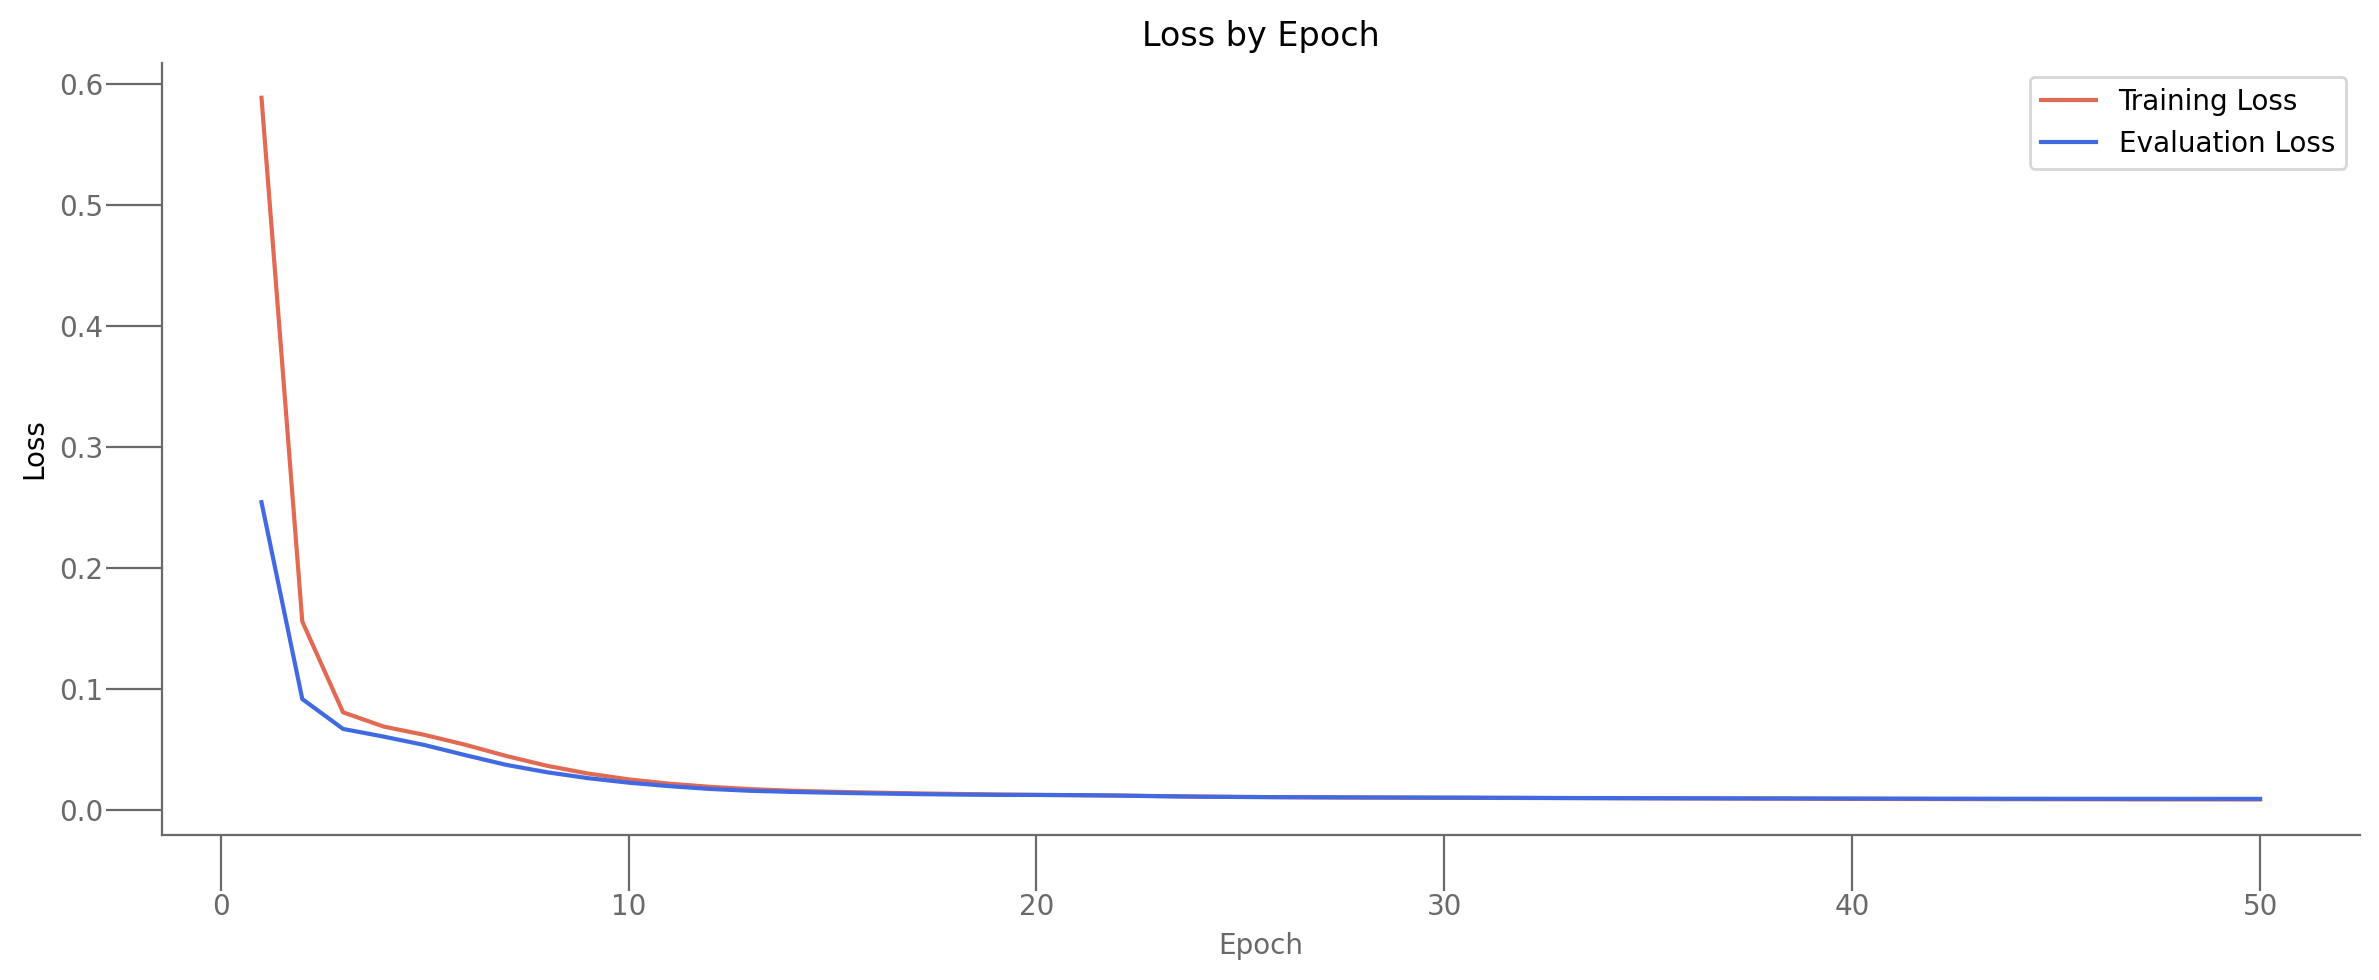


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.006968, test R2 score: -1.603802


In [18]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()



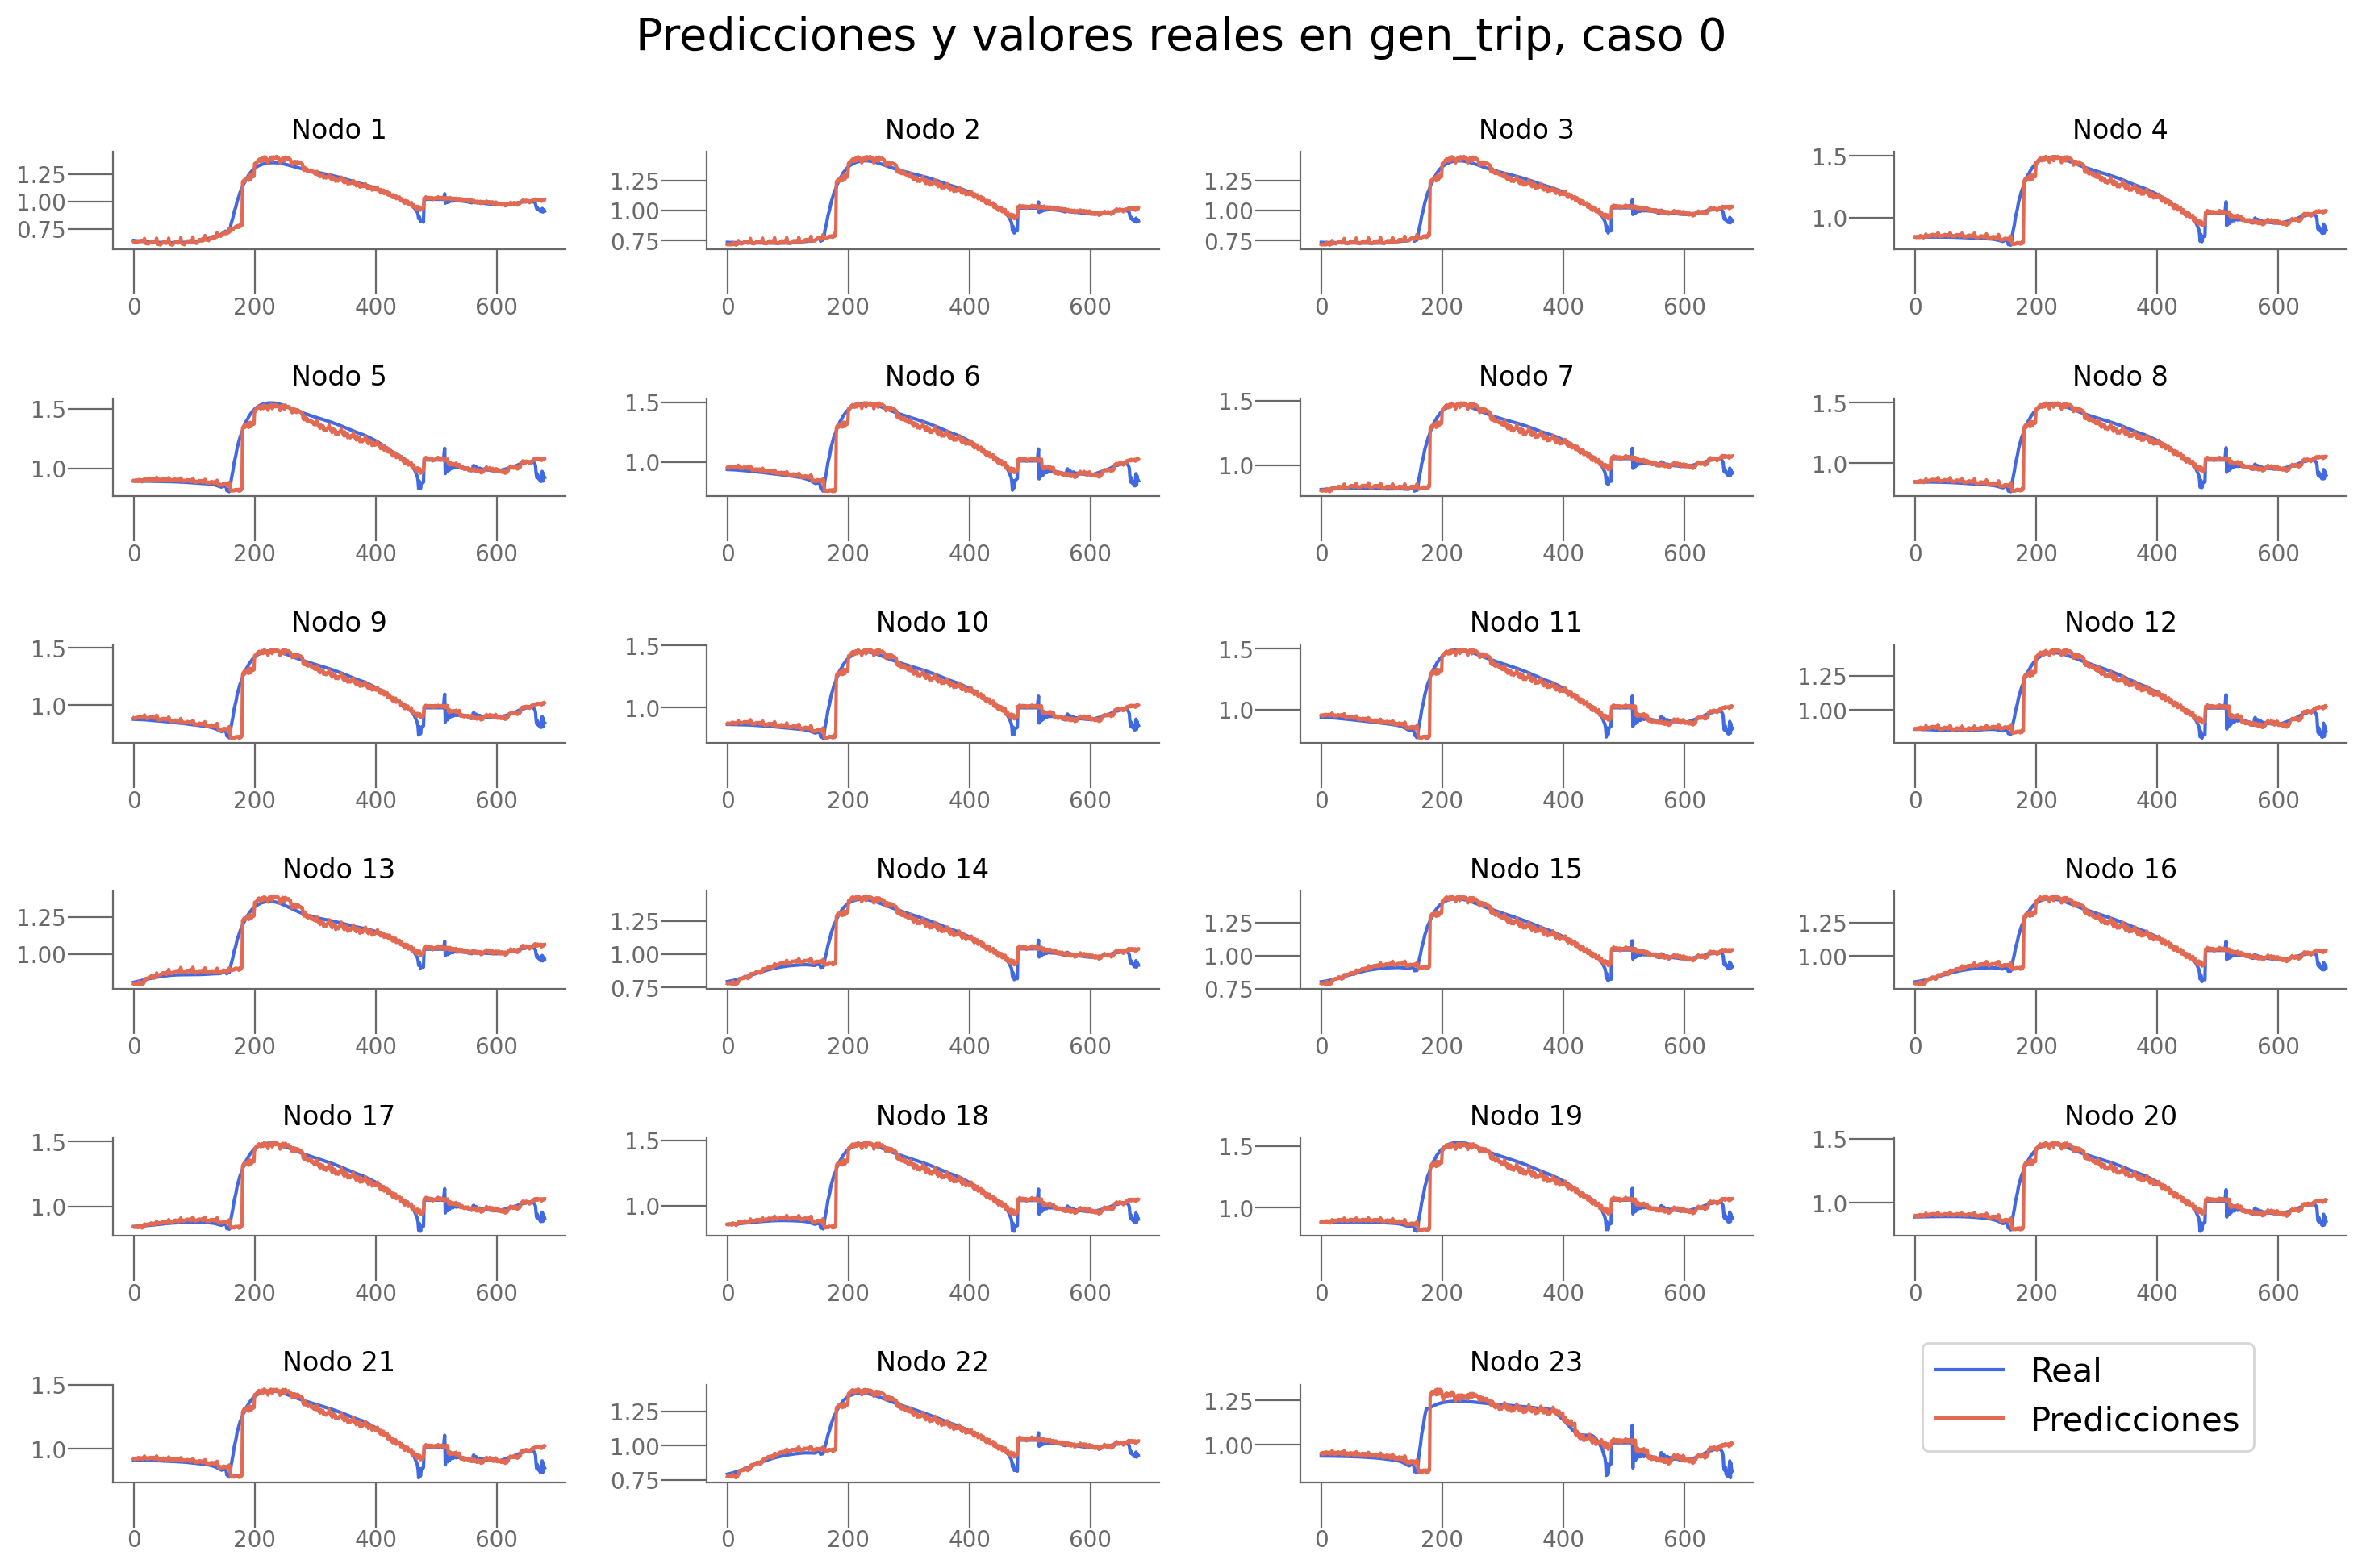

In [19]:
plot_predictions(predictions_gt, real_gt, n_target, 0, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [10]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_gt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_gt)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 4352
Validation dataset: 918
Test dataset: 952

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5530 | Eval Loss: 0.3494 | Eval R2: -154.0728 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2496 | Eval Loss: 0.1809 | Eval R2: -69.3675 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1436 | Eval Loss: 0.1135 | Eval R2: -37.2944 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0963 | Eval Loss: 0.0773 | Eval R2: -23.0338 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0668 | Eval Loss: 0.0552 | Eval R2: -15.6130 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0500 | Eval Loss: 0.0418 | Eval R2: -11.2995 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0395 | Eval Loss: 0.0335 | Eval R2: -8.6446 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0325 | Eval Loss: 0.0281 | Eval R2: -6.9214 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.0273 | Eval Loss: 0.0239 | Eval R2: -6.0532 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 0.

 25%|██▌       | 1/4 [04:36<13:48, 276.14s/it]

preds:  (1, 23, 20)
test loss: 0.007083, test R2 score: -1.876684
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.009385189972817898, 'R2_eval': -1.7064695358276367, 'Loss_eval': 0.009746594354510307, 'R2_tst': -1.876683683964485, 'Loss_tst': 0.007083203177899122, 'Loss_nodes': [0.0031254158820956945, 0.003084111725911498, 0.003997692838311195, 0.007415417581796646, 0.00871796254068613, 0.011121479794383049, 0.005005909129977226, 0.007772507146000862, 0.01028889324516058, 0.008312474936246872, 0.010868651792407036, 0.009273458272218704, 0.0027313653845340014, 0.004768208600580692, 0.005218271631747484, 0.005305351689457893, 0.007281383499503136, 0.007629932835698128, 0.008382686413824558, 0.009024693630635738, 0.009801614098250866, 0.00392893236130476, 0.009857244789600372]}

==================== DATASET INFO ===================

Train dataset: 4352
Validation dataset: 918
Test dataset: 952

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0

 50%|█████     | 2/4 [08:52<08:49, 264.66s/it]

preds:  (1, 23, 20)
test loss: 0.007409, test R2 score: -2.191077
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.008814073167741299, 'R2_eval': -1.932075023651123, 'Loss_eval': 0.009919601492583752, 'R2_tst': -2.1910772894138257, 'Loss_tst': 0.007408853154629469, 'Loss_nodes': [0.0037873208057135344, 0.0037382119335234165, 0.004584657493978739, 0.007670679595321417, 0.008770471438765526, 0.01123175397515297, 0.005331449676305056, 0.00800433661788702, 0.010472835041582584, 0.008584734983742237, 0.010991282761096954, 0.009541249834001064, 0.0031454041600227356, 0.005152593366801739, 0.005571714136749506, 0.00566063541918993, 0.0074924384243786335, 0.007858917117118835, 0.008486935868859291, 0.009256714954972267, 0.010050423443317413, 0.004359115846455097, 0.01065975334495306]}

==================== DATASET INFO ===================

Train dataset: 4352
Validation dataset: 918
Test dataset: 952

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 

 75%|███████▌  | 3/4 [13:17<04:24, 264.75s/it]

preds:  (1, 23, 20)
test loss: 0.008233, test R2 score: -2.887970
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.008173521608114243, 'R2_eval': -2.4459941387176514, 'Loss_eval': 0.010704420506954193, 'R2_tst': -2.8879695086086175, 'Loss_tst': 0.008233432658016682, 'Loss_nodes': [0.004583436530083418, 0.004538966342806816, 0.005402121692895889, 0.008452756330370903, 0.009412678889930248, 0.012005585245788097, 0.006154409609735012, 0.0087879728525877, 0.011290132068097591, 0.00943607185035944, 0.011754952371120453, 0.010375452227890491, 0.004125326871871948, 0.006048539653420448, 0.0064473338425159454, 0.006536849308758974, 0.008273902349174023, 0.008661543019115925, 0.009181979112327099, 0.010086607187986374, 0.010889389552175999, 0.005275788251310587, 0.011647198349237442]}

==================== DATASET INFO ===================

Train dataset: 4352
Validation dataset: 918
Test dataset: 952

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0

100%|██████████| 4/4 [17:50<00:00, 267.65s/it]

preds:  (1, 23, 20)
test loss: 0.008504, test R2 score: -3.105533
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.008056651800870895, 'R2_eval': -2.605437994003296, 'Loss_eval': 0.010974833741784096, 'R2_tst': -3.1055327616284814, 'Loss_tst': 0.008503866381943226, 'Loss_nodes': [0.004945093300193548, 0.0049020941369235516, 0.005752694793045521, 0.008737603202462196, 0.009642785415053368, 0.012239191681146622, 0.006437511183321476, 0.009074226021766663, 0.011568112298846245, 0.00971002597361803, 0.011987622827291489, 0.010664153844118118, 0.004388619214296341, 0.006310991942882538, 0.006705875508487225, 0.006793801672756672, 0.008525528945028782, 0.008907169103622437, 0.009418386034667492, 0.010326743125915527, 0.011130436323583126, 0.005539689213037491, 0.011880608275532722]}


In [11]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007083, test R2 score: -1.876684


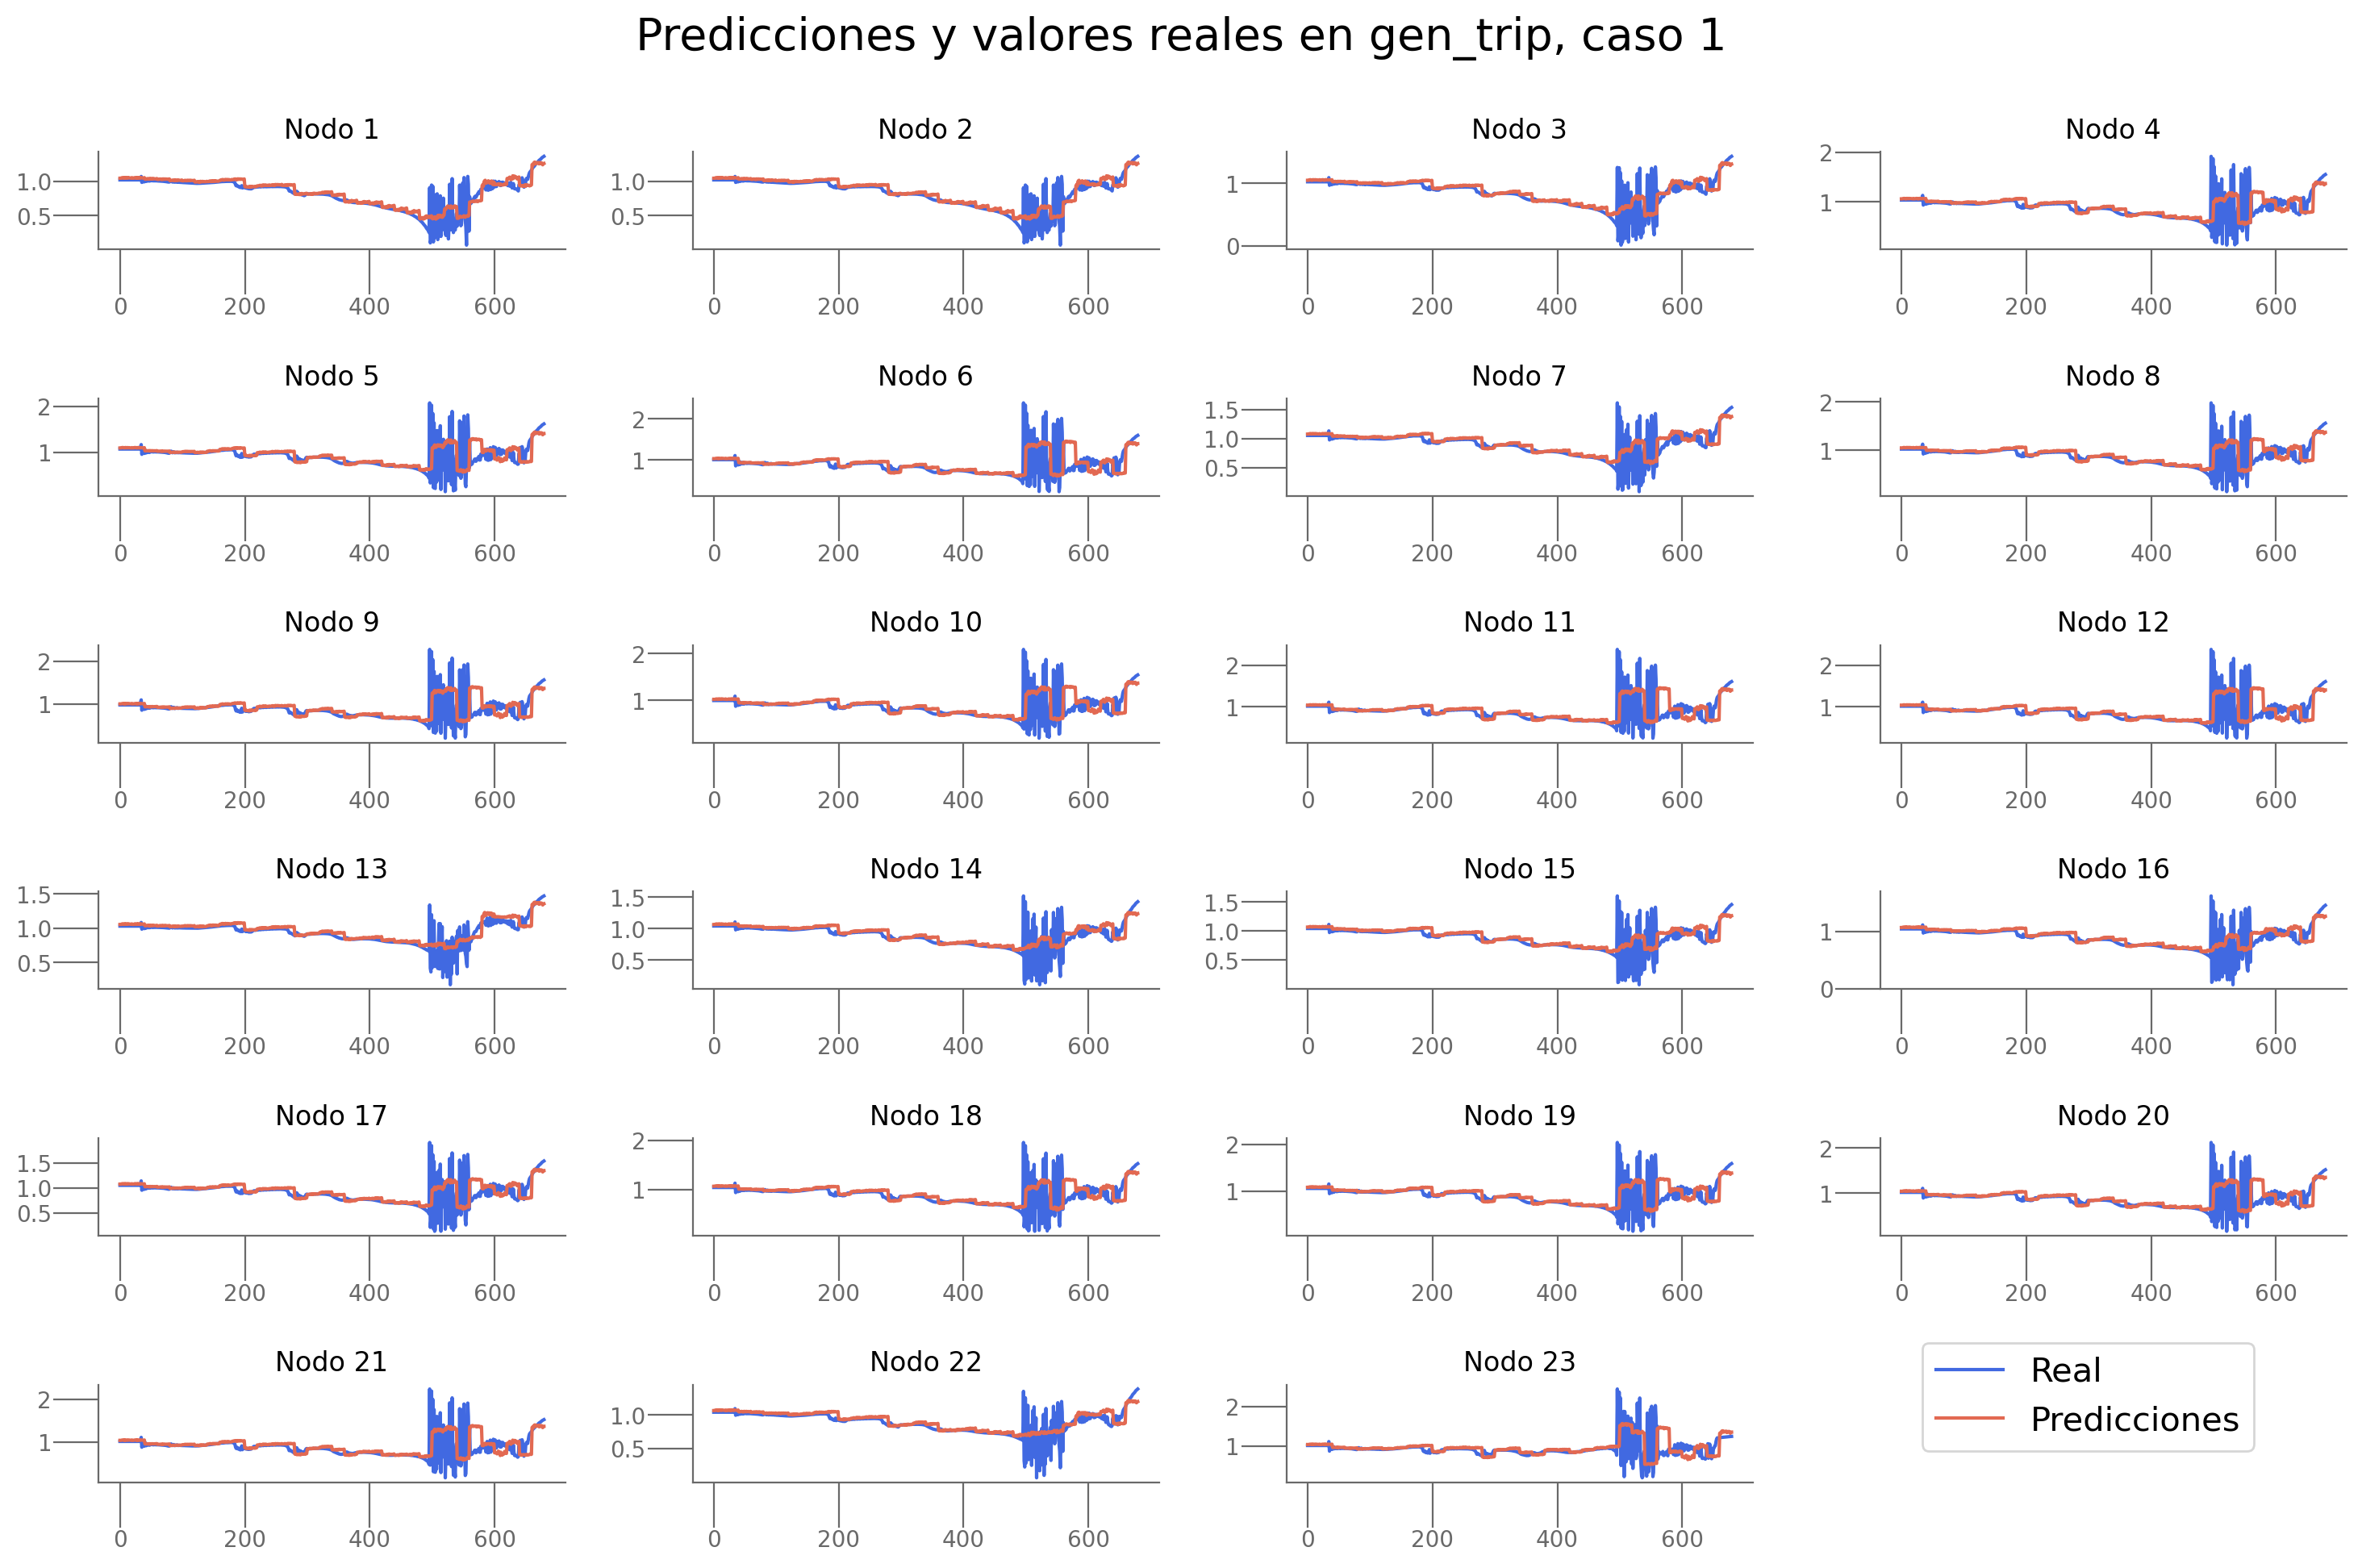

In [12]:
_,_,_, predictions_gt_ajuste,real_gt_ajuste = trainer_gt.test()
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [13]:
trainer_gt.save_model(path_save_experiment=path_save_experiment_gt, params = params_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4     EvolveGCN                                                NaN   
5        ASTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   
7        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
8         DCRNN                                     {'hidden': 10}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2   

### Bus trip

In [14]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [15]:

n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [16]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_bt,params_bt, resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.6519 | Eval Loss: 0.4046 | Eval R2: -12.5073 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3003 | Eval Loss: 0.1876 | Eval R2: -4.8216 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1458 | Eval Loss: 0.0948 | Eval R2: -1.6015 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0806 | Eval Loss: 0.0572 | Eval R2: -0.3699 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0533 | Eval Loss: 0.0421 | Eval R2: 0.0717 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0397 | Eval Loss: 0.0327 | Eval R2: 0.3417 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0314 | Eval Loss: 0.0262 | Eval R2: 0.4912 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0264 | Eval Loss: 0.0222 | Eval R2: 0.5635 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.0227 | Eval Loss: 0.0193 | Eval R2: 0.6082 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 0.0197 | Eval

 25%|██▌       | 1/4 [01:59<05:58, 119.39s/it]

preds:  (1, 23, 20)
test loss: 0.005947, test R2 score: 0.859795
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.005578671582043171, 'R2_eval': 0.8736315369606018, 'Loss_eval': 0.005535646341741085, 'R2_tst': 0.8597948397399499, 'Loss_tst': 0.005947187542915344, 'Loss_nodes': [0.0034682152327150106, 0.002762139542028308, 0.00376167637296021, 0.006899469997733831, 0.00756186805665493, 0.008298970758914948, 0.004579544998705387, 0.00792493112385273, 0.008189884014427662, 0.00685800239443779, 0.007848352193832397, 0.0044908360578119755, 0.0023067095316946507, 0.003787008812651038, 0.004505669232457876, 0.00409756088629365, 0.009793066419661045, 0.006110007409006357, 0.00788179412484169, 0.009871190413832664, 0.007257040590047836, 0.002368301386013627, 0.006163059268146753]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.725

 50%|█████     | 2/4 [03:57<03:57, 118.84s/it]

preds:  (1, 23, 20)
test loss: 0.005562, test R2 score: 0.870442
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.0053048585541546345, 'R2_eval': 0.8789723515510559, 'Loss_eval': 0.005307347979396582, 'R2_tst': 0.8704415915530999, 'Loss_tst': 0.005562294274568558, 'Loss_nodes': [0.002030534204095602, 0.0026727989315986633, 0.0037165603134781122, 0.006226354278624058, 0.007722217123955488, 0.008229431696236134, 0.004671570844948292, 0.00728223193436861, 0.008040239103138447, 0.006078742910176516, 0.0078054326586425304, 0.004497595131397247, 0.0022778513375669718, 0.003112461883574724, 0.003895431524142623, 0.0042211622931063175, 0.008542707189917564, 0.006227709818631411, 0.007283590268343687, 0.00842532329261303, 0.007224636152386665, 0.00235579302534461, 0.0053923907689750195]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss

 75%|███████▌  | 3/4 [06:00<02:00, 120.35s/it]

preds:  (1, 23, 20)
test loss: 0.004809, test R2 score: 0.885840
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.004686116240918636, 'R2_eval': 0.8947427272796631, 'Loss_eval': 0.004566308110952377, 'R2_tst': 0.8858399319225383, 'Loss_tst': 0.004808788187801838, 'Loss_nodes': [0.0017945230938494205, 0.0022093120496720076, 0.0031645495910197496, 0.0052772932685911655, 0.006476993672549725, 0.007171642035245895, 0.003943740390241146, 0.006330954376608133, 0.007032859604805708, 0.005251654889434576, 0.006779144983738661, 0.0038440327625721693, 0.002038422506302595, 0.002633180934935808, 0.003225242020562291, 0.003528598230332136, 0.007670379709452391, 0.0052675106562674046, 0.006113048642873764, 0.007536977529525757, 0.006308009847998619, 0.0020491979084908962, 0.0049548400565981865]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train 

100%|██████████| 4/4 [08:03<00:00, 120.93s/it]

preds:  (1, 23, 20)
test loss: 0.004431, test R2 score: 0.889572
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.004068754613399506, 'R2_eval': 0.9012256860733032, 'Loss_eval': 0.0040658810175955296, 'R2_tst': 0.8895724195566387, 'Loss_tst': 0.004431421868503094, 'Loss_nodes': [0.0017909426242113113, 0.0020690036471933126, 0.0028861830942332745, 0.004799133166670799, 0.005697216372936964, 0.006633972283452749, 0.003487479640170932, 0.00588587811216712, 0.006563765928149223, 0.004916429053992033, 0.006246665958315134, 0.003525821026414633, 0.001792405266314745, 0.002331644529476762, 0.002833215519785881, 0.0030857757665216923, 0.007381081581115723, 0.004759628791362047, 0.005433074664324522, 0.007270959205925465, 0.0058824908919632435, 0.0017283763736486435, 0.004921531770378351]}


In [17]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.004431, test R2 score: 0.889572


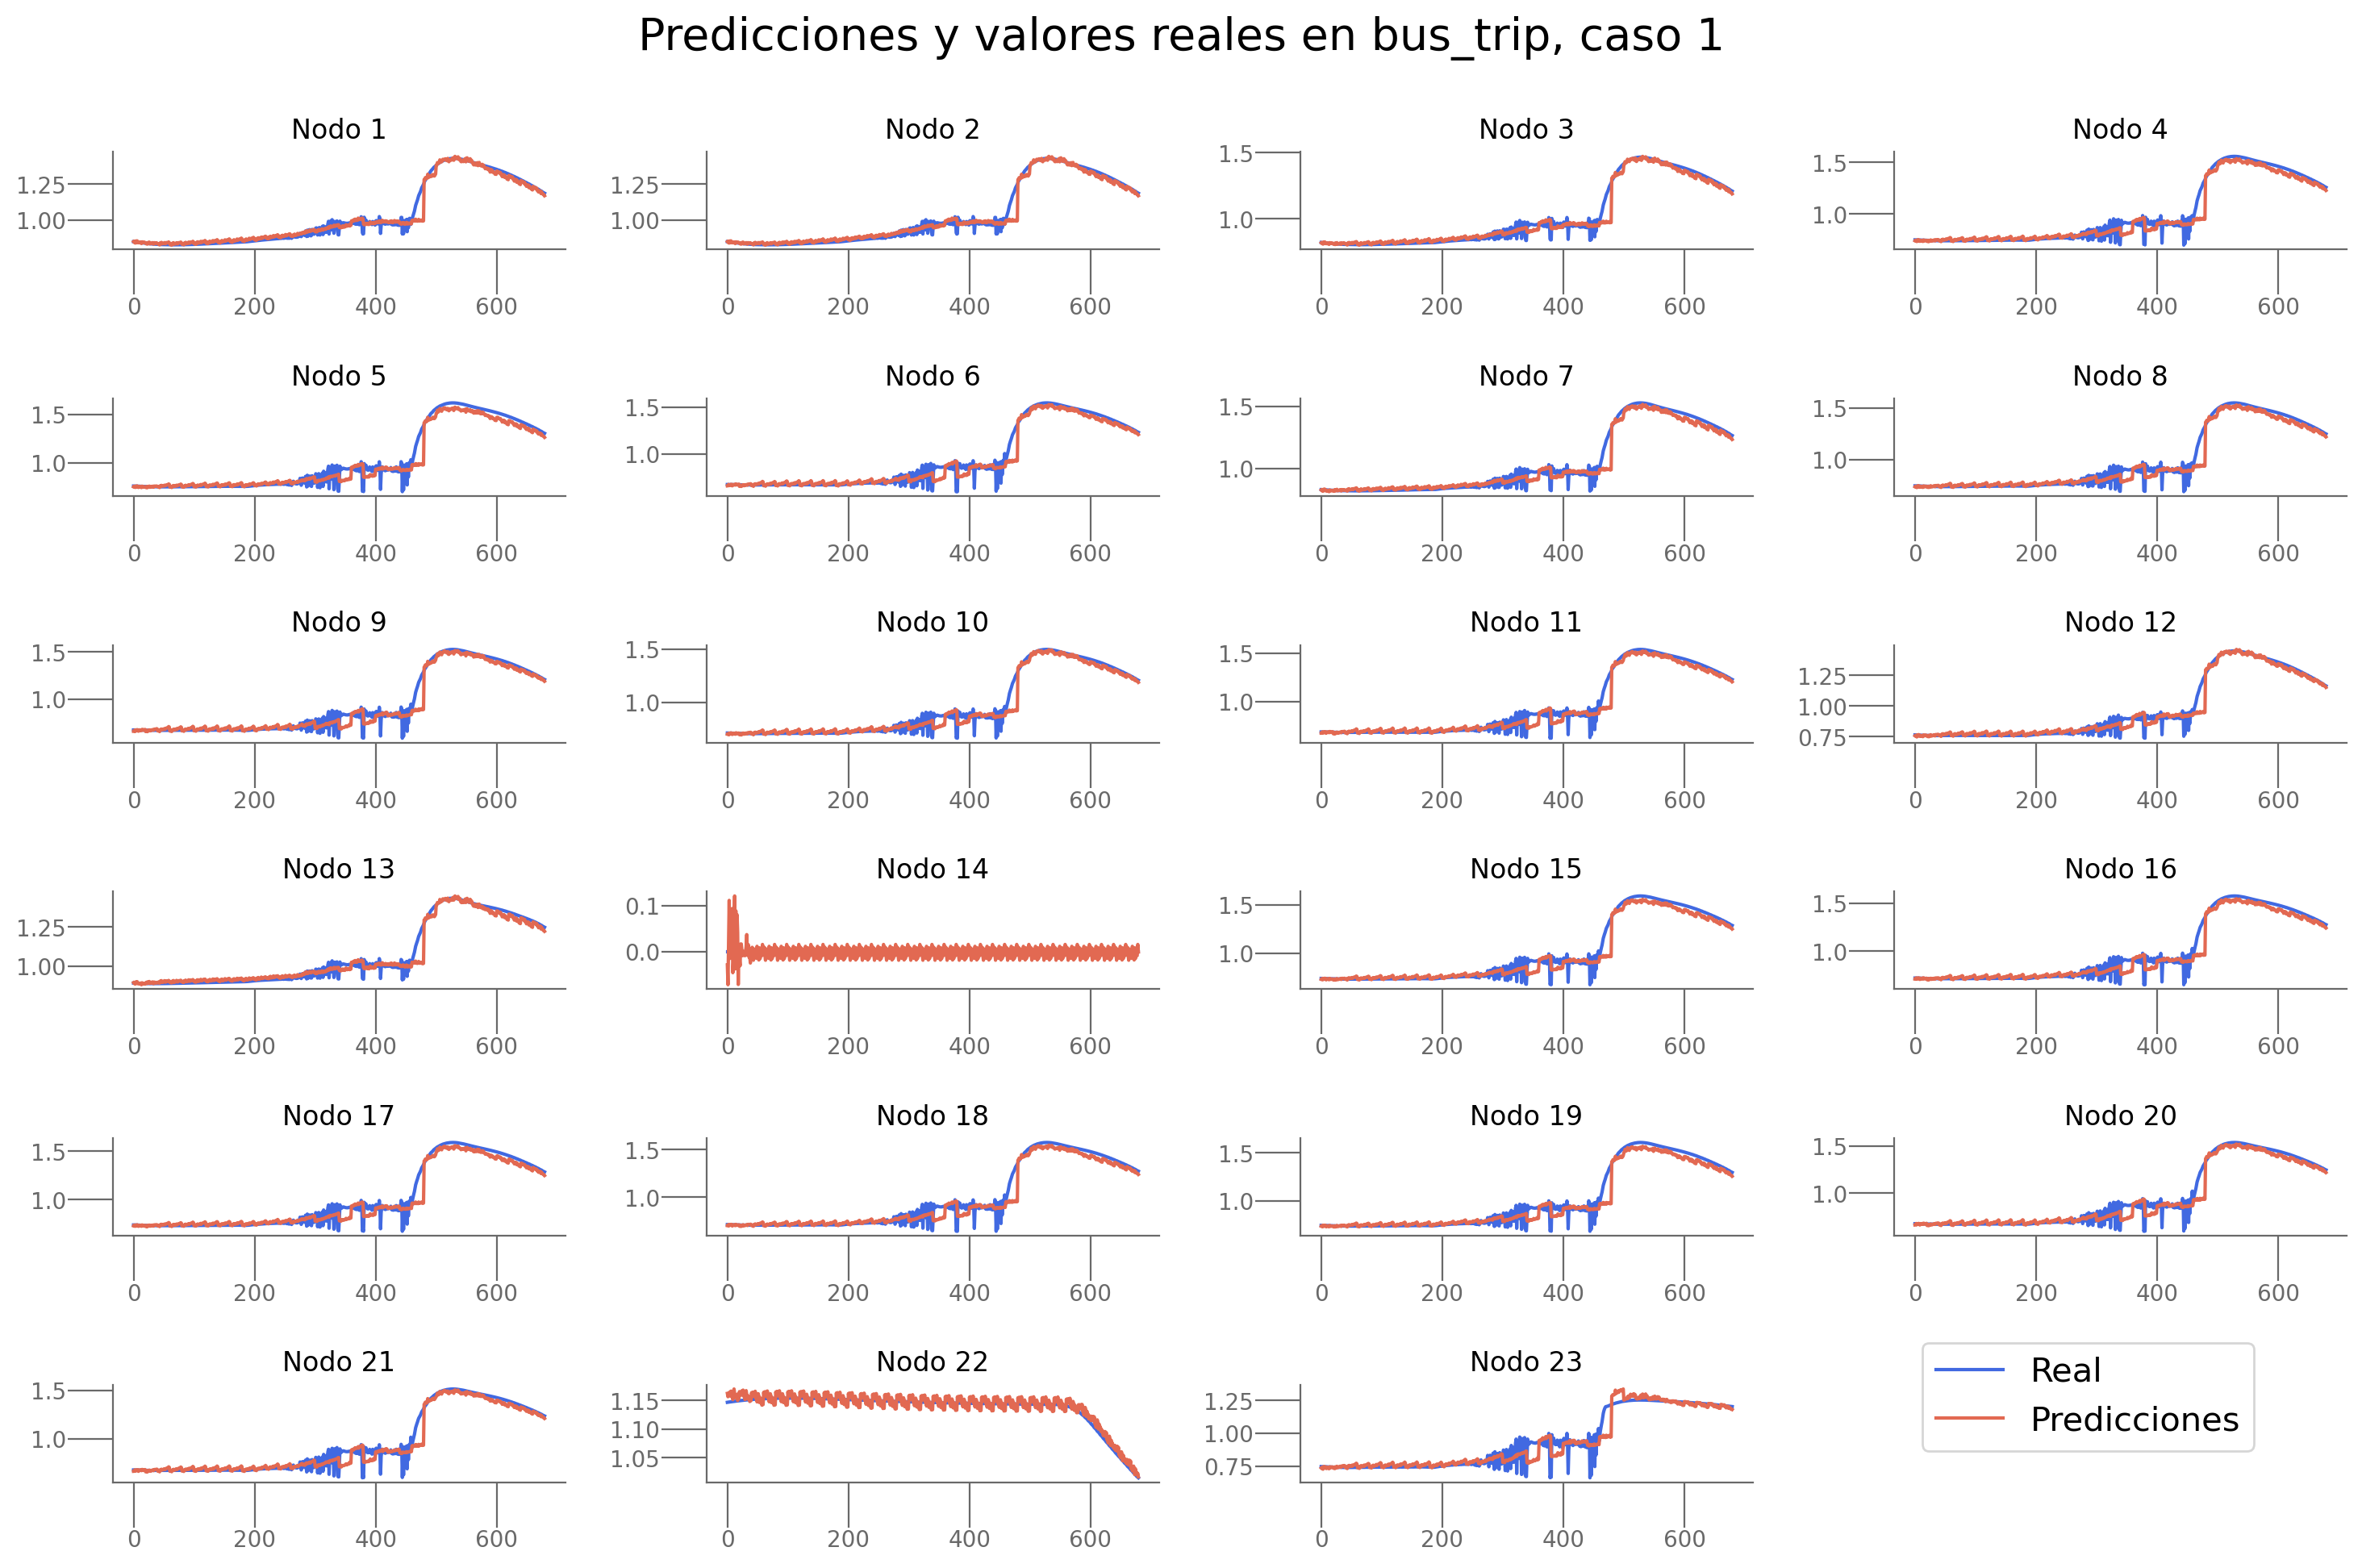

In [18]:
_,_,_, predictions_bt_ajuste,real_bt_ajuste = trainer_bt.test()
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 1, n_div_bt, problem_bt)

In [19]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params = params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4     EvolveGCN                                                NaN   
5        ASTGCN  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_...   
6         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   
7        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
8         DCRNN                                     {'hidden': 60}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./

### Bus fault

In [20]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [21]:

n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [22]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_bf,params_bf, resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.3794 | Eval Loss: 0.2435 | Eval R2: -66.1895 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.1950 | Eval Loss: 0.1385 | Eval R2: -34.7304 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1173 | Eval Loss: 0.0940 | Eval R2: -19.9265 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0819 | Eval Loss: 0.0721 | Eval R2: -12.8646 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0631 | Eval Loss: 0.0592 | Eval R2: -9.2776 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0518 | Eval Loss: 0.0513 | Eval R2: -7.4368 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0446 | Eval Loss: 0.0466 | Eval R2: -6.6219 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0398 | Eval Loss: 0.0437 | Eval R2: -6.1635 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.0363 | Eval Loss: 0.0408 | Eval R2: -5.5980 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 0.033

 25%|██▌       | 1/4 [01:59<05:59, 119.77s/it]

preds:  (1, 23, 20)
test loss: 0.018385, test R2 score: -1.288465
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.018770117312669754, 'R2_eval': -2.7504189014434814, 'Loss_eval': 0.025019187480211258, 'R2_tst': -1.2884651135120666, 'Loss_tst': 0.01838531717658043, 'Loss_nodes': [0.014081230387091637, 0.012333971448242664, 0.014585562981665134, 0.0200850497931242, 0.02270607464015484, 0.024442140012979507, 0.016723202541470528, 0.020547691732645035, 0.02560599520802498, 0.020003704354166985, 0.023454200476408005, 0.014316029846668243, 0.01113897655159235, 0.014393544755876064, 0.014871712774038315, 0.015993548557162285, 0.02003663033246994, 0.02114063873887062, 0.02214735373854637, 0.021742558106780052, 0.022129766643047333, 0.012775631621479988, 0.017607100307941437]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.3697 |

 50%|█████     | 2/4 [04:07<04:08, 124.18s/it]

preds:  (1, 23, 20)
test loss: 0.018191, test R2 score: -1.314094
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.018764851614832878, 'R2_eval': -2.793818712234497, 'Loss_eval': 0.024679485708475113, 'R2_tst': -1.3140939556765083, 'Loss_tst': 0.0181907769292593, 'Loss_nodes': [0.013351966626942158, 0.012478241696953773, 0.014707664959132671, 0.020009392872452736, 0.022598139941692352, 0.024295099079608917, 0.016736283898353577, 0.02046017162501812, 0.02390039525926113, 0.019857507199048996, 0.023285072296857834, 0.0142282759770751, 0.011412695050239563, 0.014359798282384872, 0.01480969786643982, 0.0159479808062315, 0.019977185875177383, 0.020470455288887024, 0.02168288081884384, 0.02151953987777233, 0.02201482281088829, 0.012828182429075241, 0.01745646633207798]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.2493 | Eval

 75%|███████▌  | 3/4 [06:11<02:04, 124.47s/it]

preds:  (1, 23, 20)
test loss: 0.016691, test R2 score: -0.842218
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.018196377903223038, 'R2_eval': -2.3064939975738525, 'Loss_eval': 0.023515308275818825, 'R2_tst': -0.8422175517564876, 'Loss_tst': 0.016691483557224274, 'Loss_nodes': [0.011957120150327682, 0.01082636322826147, 0.01312737911939621, 0.01858406886458397, 0.020977409556508064, 0.02298566699028015, 0.015098169445991516, 0.019076664000749588, 0.02328410930931568, 0.018593747168779373, 0.021942004561424255, 0.012816281989216805, 0.0092747388407588, 0.01245744340121746, 0.01298356894403696, 0.014215013943612576, 0.01839854195713997, 0.019217396154999733, 0.02033223770558834, 0.020215105265378952, 0.02071697637438774, 0.010510626249015331, 0.01631350629031658]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.1795 | Eva

100%|██████████| 4/4 [08:20<00:00, 125.01s/it]

preds:  (1, 23, 20)
test loss: 0.017001, test R2 score: -0.897721
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.01787523180246353, 'R2_eval': -2.261589527130127, 'Loss_eval': 0.023369841277599335, 'R2_tst': -0.897720511543778, 'Loss_tst': 0.01700061932206154, 'Loss_nodes': [0.011817305348813534, 0.01116905640810728, 0.013387788087129593, 0.018966520205140114, 0.02138163335621357, 0.0233655646443367, 0.015444250777363777, 0.019442027434706688, 0.023431096225976944, 0.01897546276450157, 0.022326406091451645, 0.01317379530519247, 0.009466047398746014, 0.012715120799839497, 0.013214902952313423, 0.014525930397212505, 0.018757902085781097, 0.019550196826457977, 0.02068636193871498, 0.020581310614943504, 0.02112160623073578, 0.010711144655942917, 0.016802821308374405]}


In [23]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.016691, test R2 score: -0.842218


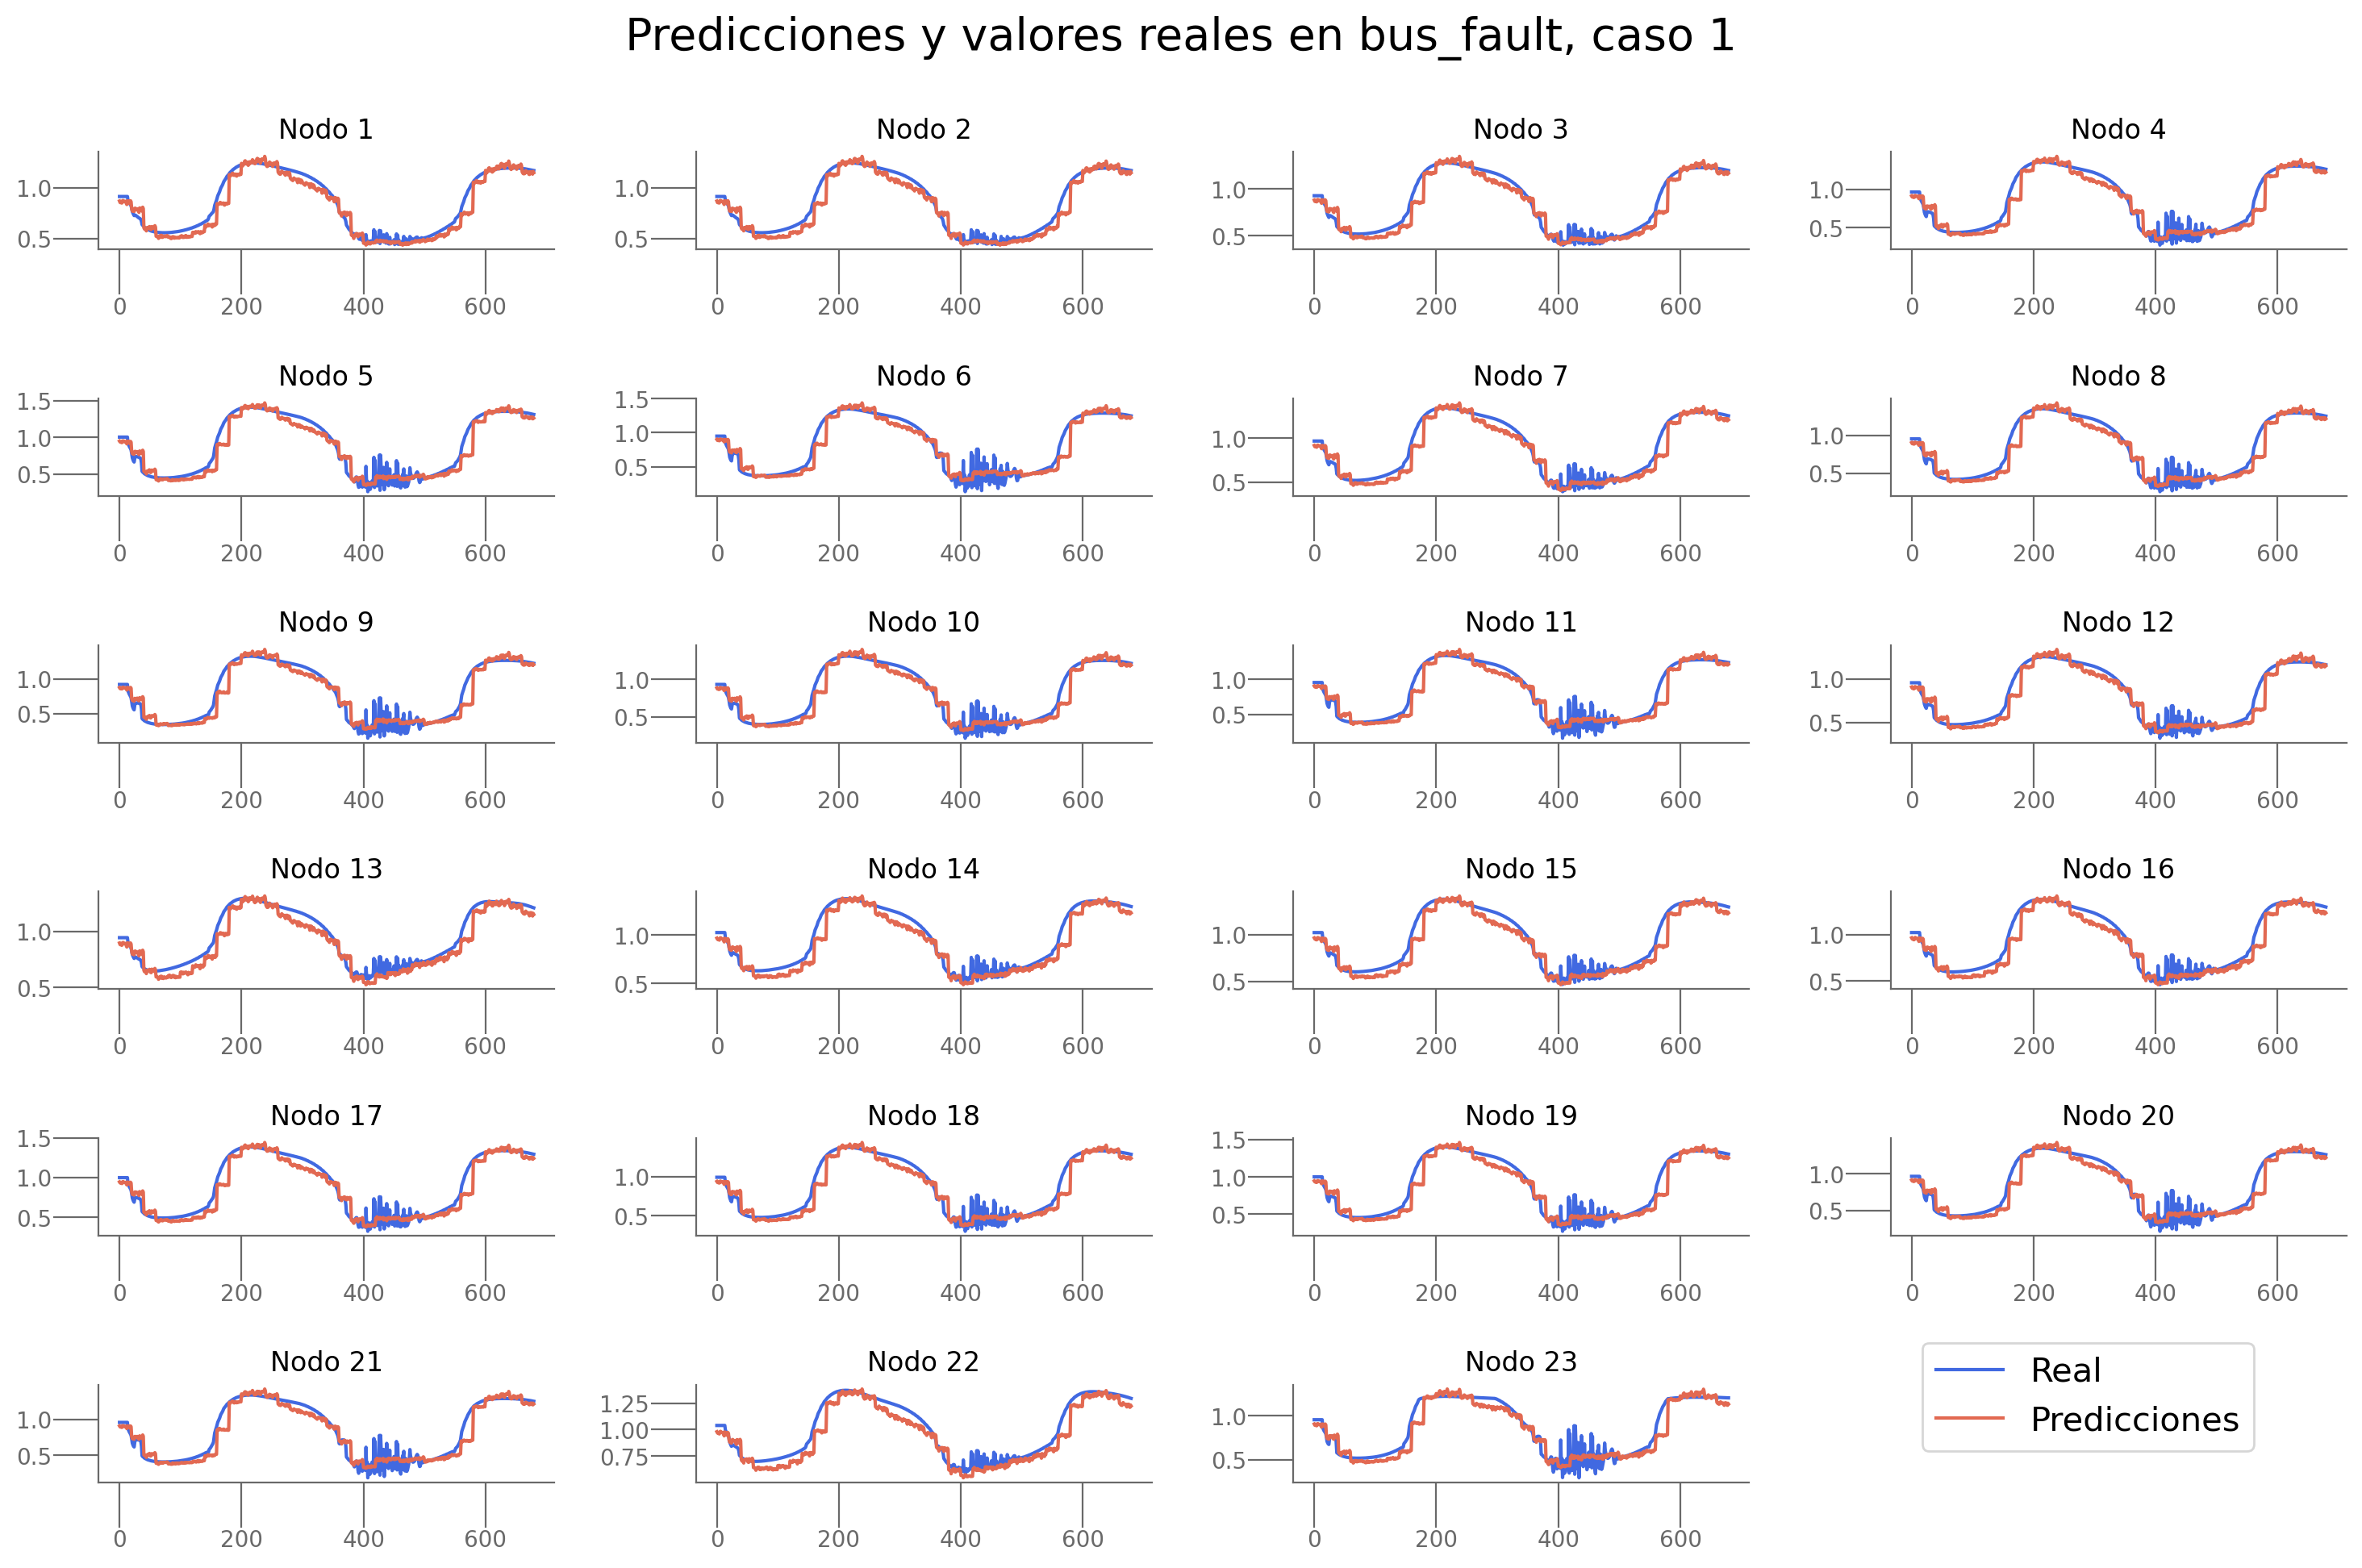

In [24]:
_,_,_, predictions_bf_ajuste,real_bf_ajuste = trainer_bf.test()
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 1, n_div_bf, problem_bf)

In [25]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params = params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
5     EvolveGCN                                                NaN   
6        ASTGCN  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_...   
7         AGCRN            {'hidden': 15, 'K': 10, 'embedding': 3}   
8         DCRNN                                     {'hidden': 40}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.017298   0.603716   
1                                                NaN  0.017459  -1.122112   
2   

### Branch Fault

In [26]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [27]:

n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [28]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_brf,params_brf, resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.2815 | Eval Loss: 0.2504 | Eval R2: -28.9939 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.1407 | Eval Loss: 0.1500 | Eval R2: -17.3786 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.0891 | Eval Loss: 0.1081 | Eval R2: -12.1450 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0671 | Eval Loss: 0.0862 | Eval R2: -9.3312 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0550 | Eval Loss: 0.0719 | Eval R2: -7.4076 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0472 | Eval Loss: 0.0624 | Eval R2: -6.0841 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0422 | Eval Loss: 0.0559 | Eval R2: -5.2668 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0385 | Eval Loss: 0.0506 | Eval R2: -4.7489 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.0355 | Eval Loss: 0.0462 | Eval R2: -4.4061 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 0.0330

 25%|██▌       | 1/4 [02:09<06:27, 129.24s/it]

preds:  (1, 23, 20)
test loss: 0.021834, test R2 score: -1.666710
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.020502129569649696, 'R2_eval': -2.7116315364837646, 'Loss_eval': 0.02652204968035221, 'R2_tst': -1.6667100919096043, 'Loss_tst': 0.021834056824445724, 'Loss_nodes': [0.006666203029453754, 0.006666203029453754, 0.010726919397711754, 0.022172091528773308, 0.02582891844213009, 0.03017370216548443, 0.015643883496522903, 0.022864844650030136, 0.029776258394122124, 0.023357687518000603, 0.029860392212867737, 0.018061526119709015, 0.007263700477778912, 0.022227350622415543, 0.02386459708213806, 0.024058865383267403, 0.02686292491853237, 0.02913161925971508, 0.026312584057450294, 0.03043903224170208, 0.028882542625069618, 0.017262732610106468, 0.02407866343855858]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.2680 

 50%|█████     | 2/4 [04:16<04:16, 128.19s/it]

preds:  (1, 23, 20)
test loss: 0.021665, test R2 score: -1.655586
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.02034391276538372, 'R2_eval': -2.7603745460510254, 'Loss_eval': 0.026860184967517853, 'R2_tst': -1.6555857432364378, 'Loss_tst': 0.02166500873863697, 'Loss_nodes': [0.0066333371214568615, 0.0066333371214568615, 0.010269791819155216, 0.02205650880932808, 0.025509610772132874, 0.03014903888106346, 0.015180396847426891, 0.022858919575810432, 0.029799532145261765, 0.02339784987270832, 0.029829110950231552, 0.018017414957284927, 0.007267414126545191, 0.02208678051829338, 0.0236698966473341, 0.023863615468144417, 0.026757463812828064, 0.028365900740027428, 0.026092953979969025, 0.029788518324494362, 0.028782544657588005, 0.01723688840866089, 0.02404842898249626]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.1874 

 75%|███████▌  | 3/4 [06:27<02:09, 129.19s/it]

preds:  (1, 23, 20)
test loss: 0.021044, test R2 score: -1.760601
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.019519029185175896, 'R2_eval': -2.852989435195923, 'Loss_eval': 0.026276519522070885, 'R2_tst': -1.7606008116694134, 'Loss_tst': 0.02104428969323635, 'Loss_nodes': [0.007372792344540358, 0.007372792344540358, 0.010599518194794655, 0.021183107048273087, 0.02441125176846981, 0.02899486944079399, 0.01526254415512085, 0.02204534411430359, 0.028701862320303917, 0.022578127682209015, 0.02875581942498684, 0.017760707065463066, 0.008196057751774788, 0.021440541371703148, 0.022836361080408096, 0.022990981116890907, 0.025537703186273575, 0.027098406106233597, 0.024889733642339706, 0.028295885771512985, 0.027435267344117165, 0.01721462979912758, 0.02304433099925518]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.1454 |

100%|██████████| 4/4 [08:41<00:00, 130.50s/it]

preds:  (1, 23, 20)
test loss: 0.020740, test R2 score: -1.743957
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.0195689145475626, 'R2_eval': -2.8388917446136475, 'Loss_eval': 0.025899160653352737, 'R2_tst': -1.7439570916440057, 'Loss_tst': 0.02074003592133522, 'Loss_nodes': [0.007276752032339573, 0.007276752032339573, 0.010637735016644001, 0.0209808349609375, 0.024214619770646095, 0.028670327737927437, 0.015262303873896599, 0.021807631477713585, 0.028305580839514732, 0.02232692763209343, 0.028430568054318428, 0.017453020438551903, 0.008080094121396542, 0.020936269313097, 0.022301390767097473, 0.02248498797416687, 0.024921022355556488, 0.026623452082276344, 0.02460203506052494, 0.028039874508976936, 0.027073152363300323, 0.016733916476368904, 0.022581588476896286]}


In [29]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.020740, test R2 score: -1.743957


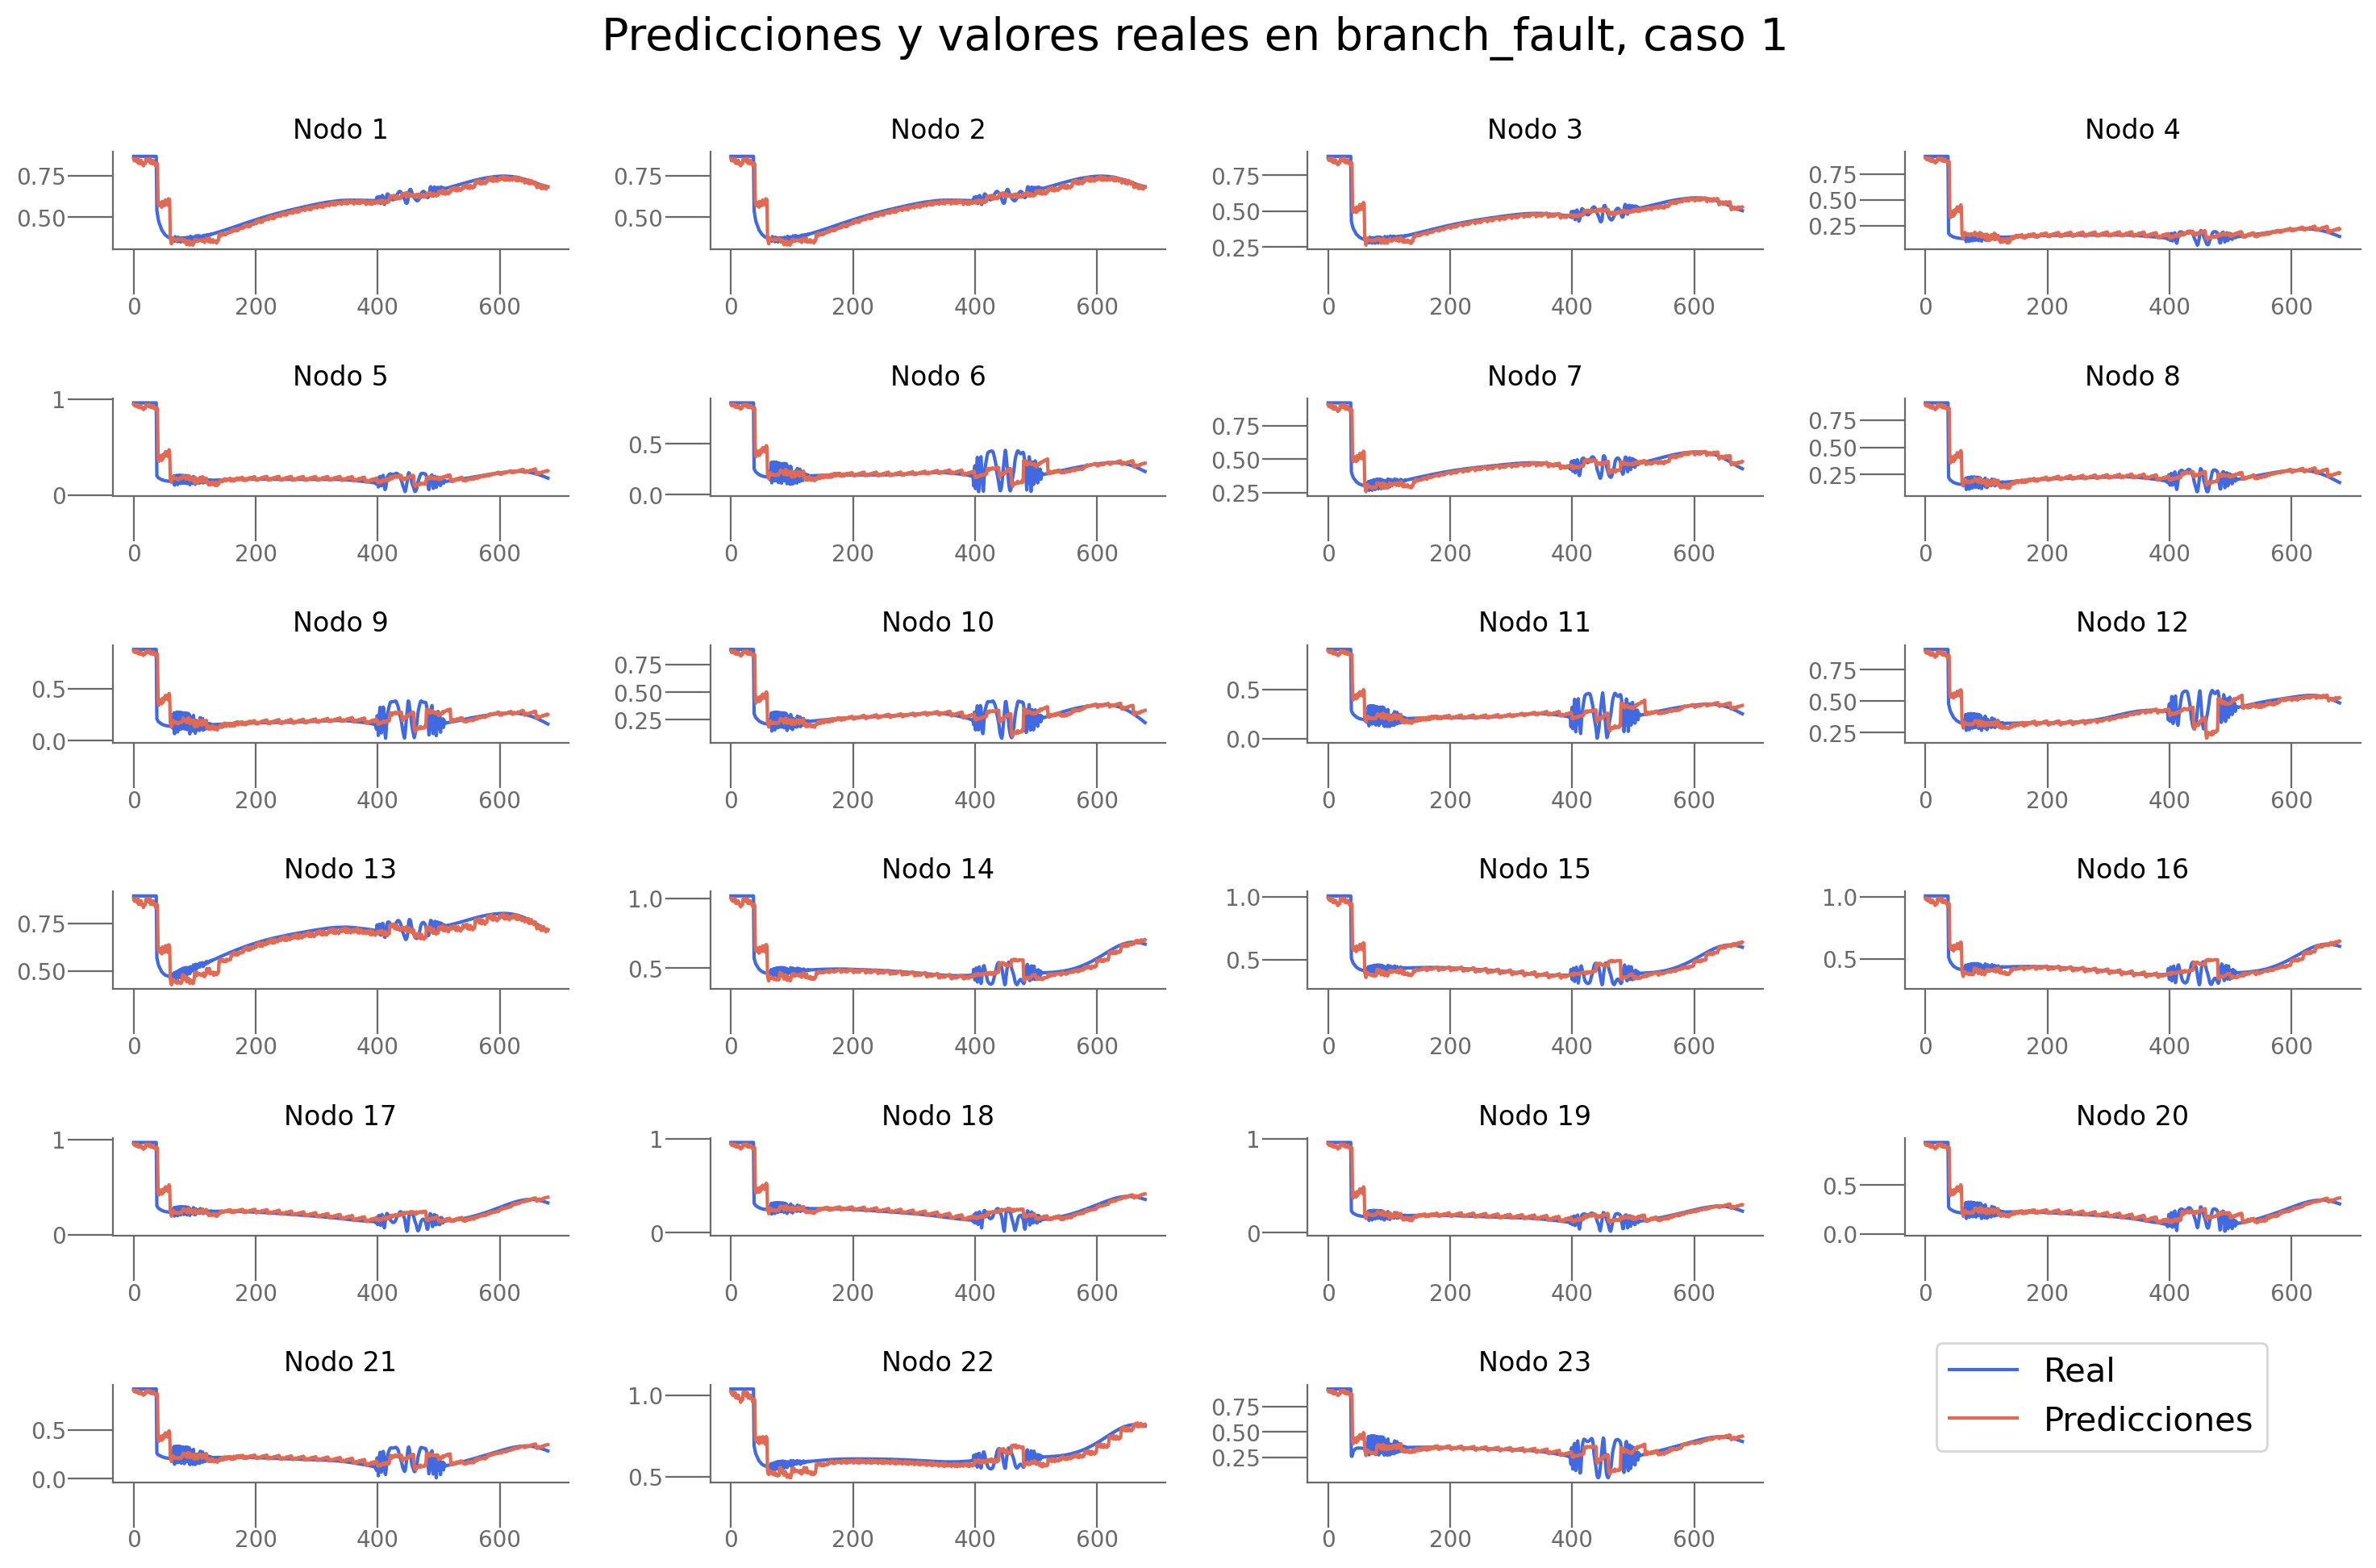

In [30]:
_,_,_, predictions_brf_ajuste,real_brf_ajuste = trainer_brf.test()
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 1, n_div_brf, problem_brf)

In [31]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params = params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
5     EvolveGCN                                                NaN   
6        ASTGCN                                                NaN   
7         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   
8         DCRNN                                     {'hidden': 60}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.023216   0.608045   
1                                                NaN  0.021628  -1.528487   
2  .

### Branch trip

In [32]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [33]:

n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [34]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_brt,params_brt, resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.6556 | Eval Loss: 0.4416 | Eval R2: -368.2017 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2999 | Eval Loss: 0.1906 | Eval R2: -154.7302 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1261 | Eval Loss: 0.0849 | Eval R2: -63.3088 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0605 | Eval Loss: 0.0480 | Eval R2: -31.3970 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0374 | Eval Loss: 0.0330 | Eval R2: -19.2772 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0269 | Eval Loss: 0.0255 | Eval R2: -12.9029 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0212 | Eval Loss: 0.0199 | Eval R2: -10.1546 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0176 | Eval Loss: 0.0161 | Eval R2: -7.9523 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.0152 | Eval Loss: 0.0151 | Eval R2: -7.9686 | LR: 0.0010 | 
Epoch 10/100 | Train Loss: 

 25%|██▌       | 1/4 [02:21<07:05, 141.99s/it]

preds:  (1, 23, 20)
test loss: 0.003529, test R2 score: -1.224393
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.0040578353218734264, 'R2_eval': -1.156509518623352, 'Loss_eval': 0.003504079068079591, 'R2_tst': -1.2243926699623795, 'Loss_tst': 0.0035292739048600197, 'Loss_nodes': [0.0022105786483734846, 0.001857197959907353, 0.002548975870013237, 0.0038354559801518917, 0.004465797450393438, 0.005508182570338249, 0.0027796330396085978, 0.004085857421159744, 0.005502650979906321, 0.004103372804820538, 0.005227216053754091, 0.003321184078231454, 0.001794716576114297, 0.002233021892607212, 0.002466385019943118, 0.0027157217264175415, 0.0035705212503671646, 0.0037357863038778305, 0.00424202298745513, 0.00441588182002306, 0.004728992003947496, 0.0018572091357782483, 0.00396694615483284]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== TRAIN INFO ===================

Epoch 1/100 | Train 

 50%|█████     | 2/4 [04:42<04:42, 141.04s/it]

preds:  (1, 23, 20)
test loss: 0.003826, test R2 score: -1.315746
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.004451780114322901, 'R2_eval': -1.1776807308197021, 'Loss_eval': 0.0035806121304631233, 'R2_tst': -1.315745579945062, 'Loss_tst': 0.003825661726295948, 'Loss_nodes': [0.002167663536965847, 0.0017615051474422216, 0.002629657741636038, 0.0042447117157280445, 0.005330224521458149, 0.0058995941653847694, 0.0032442600931972265, 0.004470489453524351, 0.005729431752115488, 0.004550355486571789, 0.005616388749331236, 0.0034353083465248346, 0.0019140219083055854, 0.002438855357468128, 0.002728174440562725, 0.0030420294497162104, 0.004055501893162727, 0.0041588605381548405, 0.004961520433425903, 0.004719814285635948, 0.005004290957003832, 0.001998827327042818, 0.003888722974807024]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== TRAIN INFO ===================

Epoch 1/100 | Tra

 75%|███████▌  | 3/4 [07:00<02:19, 139.73s/it]

preds:  (1, 23, 20)
test loss: 0.003558, test R2 score: -1.337516
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.0038822125643491745, 'R2_eval': -1.2745122909545898, 'Loss_eval': 0.003596130758523941, 'R2_tst': -1.3375158832701386, 'Loss_tst': 0.0035580971743911505, 'Loss_nodes': [0.0023157955147325993, 0.0019754262175410986, 0.0026347388047724962, 0.00384076707996428, 0.004284362308681011, 0.005490930750966072, 0.0027326783165335655, 0.004093445371836424, 0.005541164427995682, 0.004039107821881771, 0.005209330469369888, 0.0034107689280062914, 0.0018446845933794975, 0.002328671980649233, 0.002546312054619193, 0.002768623875454068, 0.003564442042261362, 0.0037506078369915485, 0.004126918502151966, 0.004460454918444157, 0.004775702487677336, 0.0019599709194153547, 0.004141329322010279]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== TRAIN INFO ===================

Epoch 1/100 | Tr

100%|██████████| 4/4 [09:27<00:00, 141.91s/it]

preds:  (1, 23, 20)
test loss: 0.003512, test R2 score: -1.369519
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.0037785011809319258, 'R2_eval': -1.3250231742858887, 'Loss_eval': 0.003597205737605691, 'R2_tst': -1.3695187680624747, 'Loss_tst': 0.0035116448998451233, 'Loss_nodes': [0.0023908603470772505, 0.0020713824778795242, 0.0026651034131646156, 0.003742080181837082, 0.004050010349601507, 0.005385861732065678, 0.0026605287566781044, 0.003989999182522297, 0.005446815397590399, 0.003929111175239086, 0.005113409366458654, 0.0034147517289966345, 0.0019185724668204784, 0.0023178684059530497, 0.0025119648780673742, 0.0027246156241744757, 0.003453427692875266, 0.0036615771241486073, 0.0039408220909535885, 0.004401884973049164, 0.004726098384708166, 0.001982876332476735, 0.0042682127095758915]}


In [35]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.003512, test R2 score: -1.369519


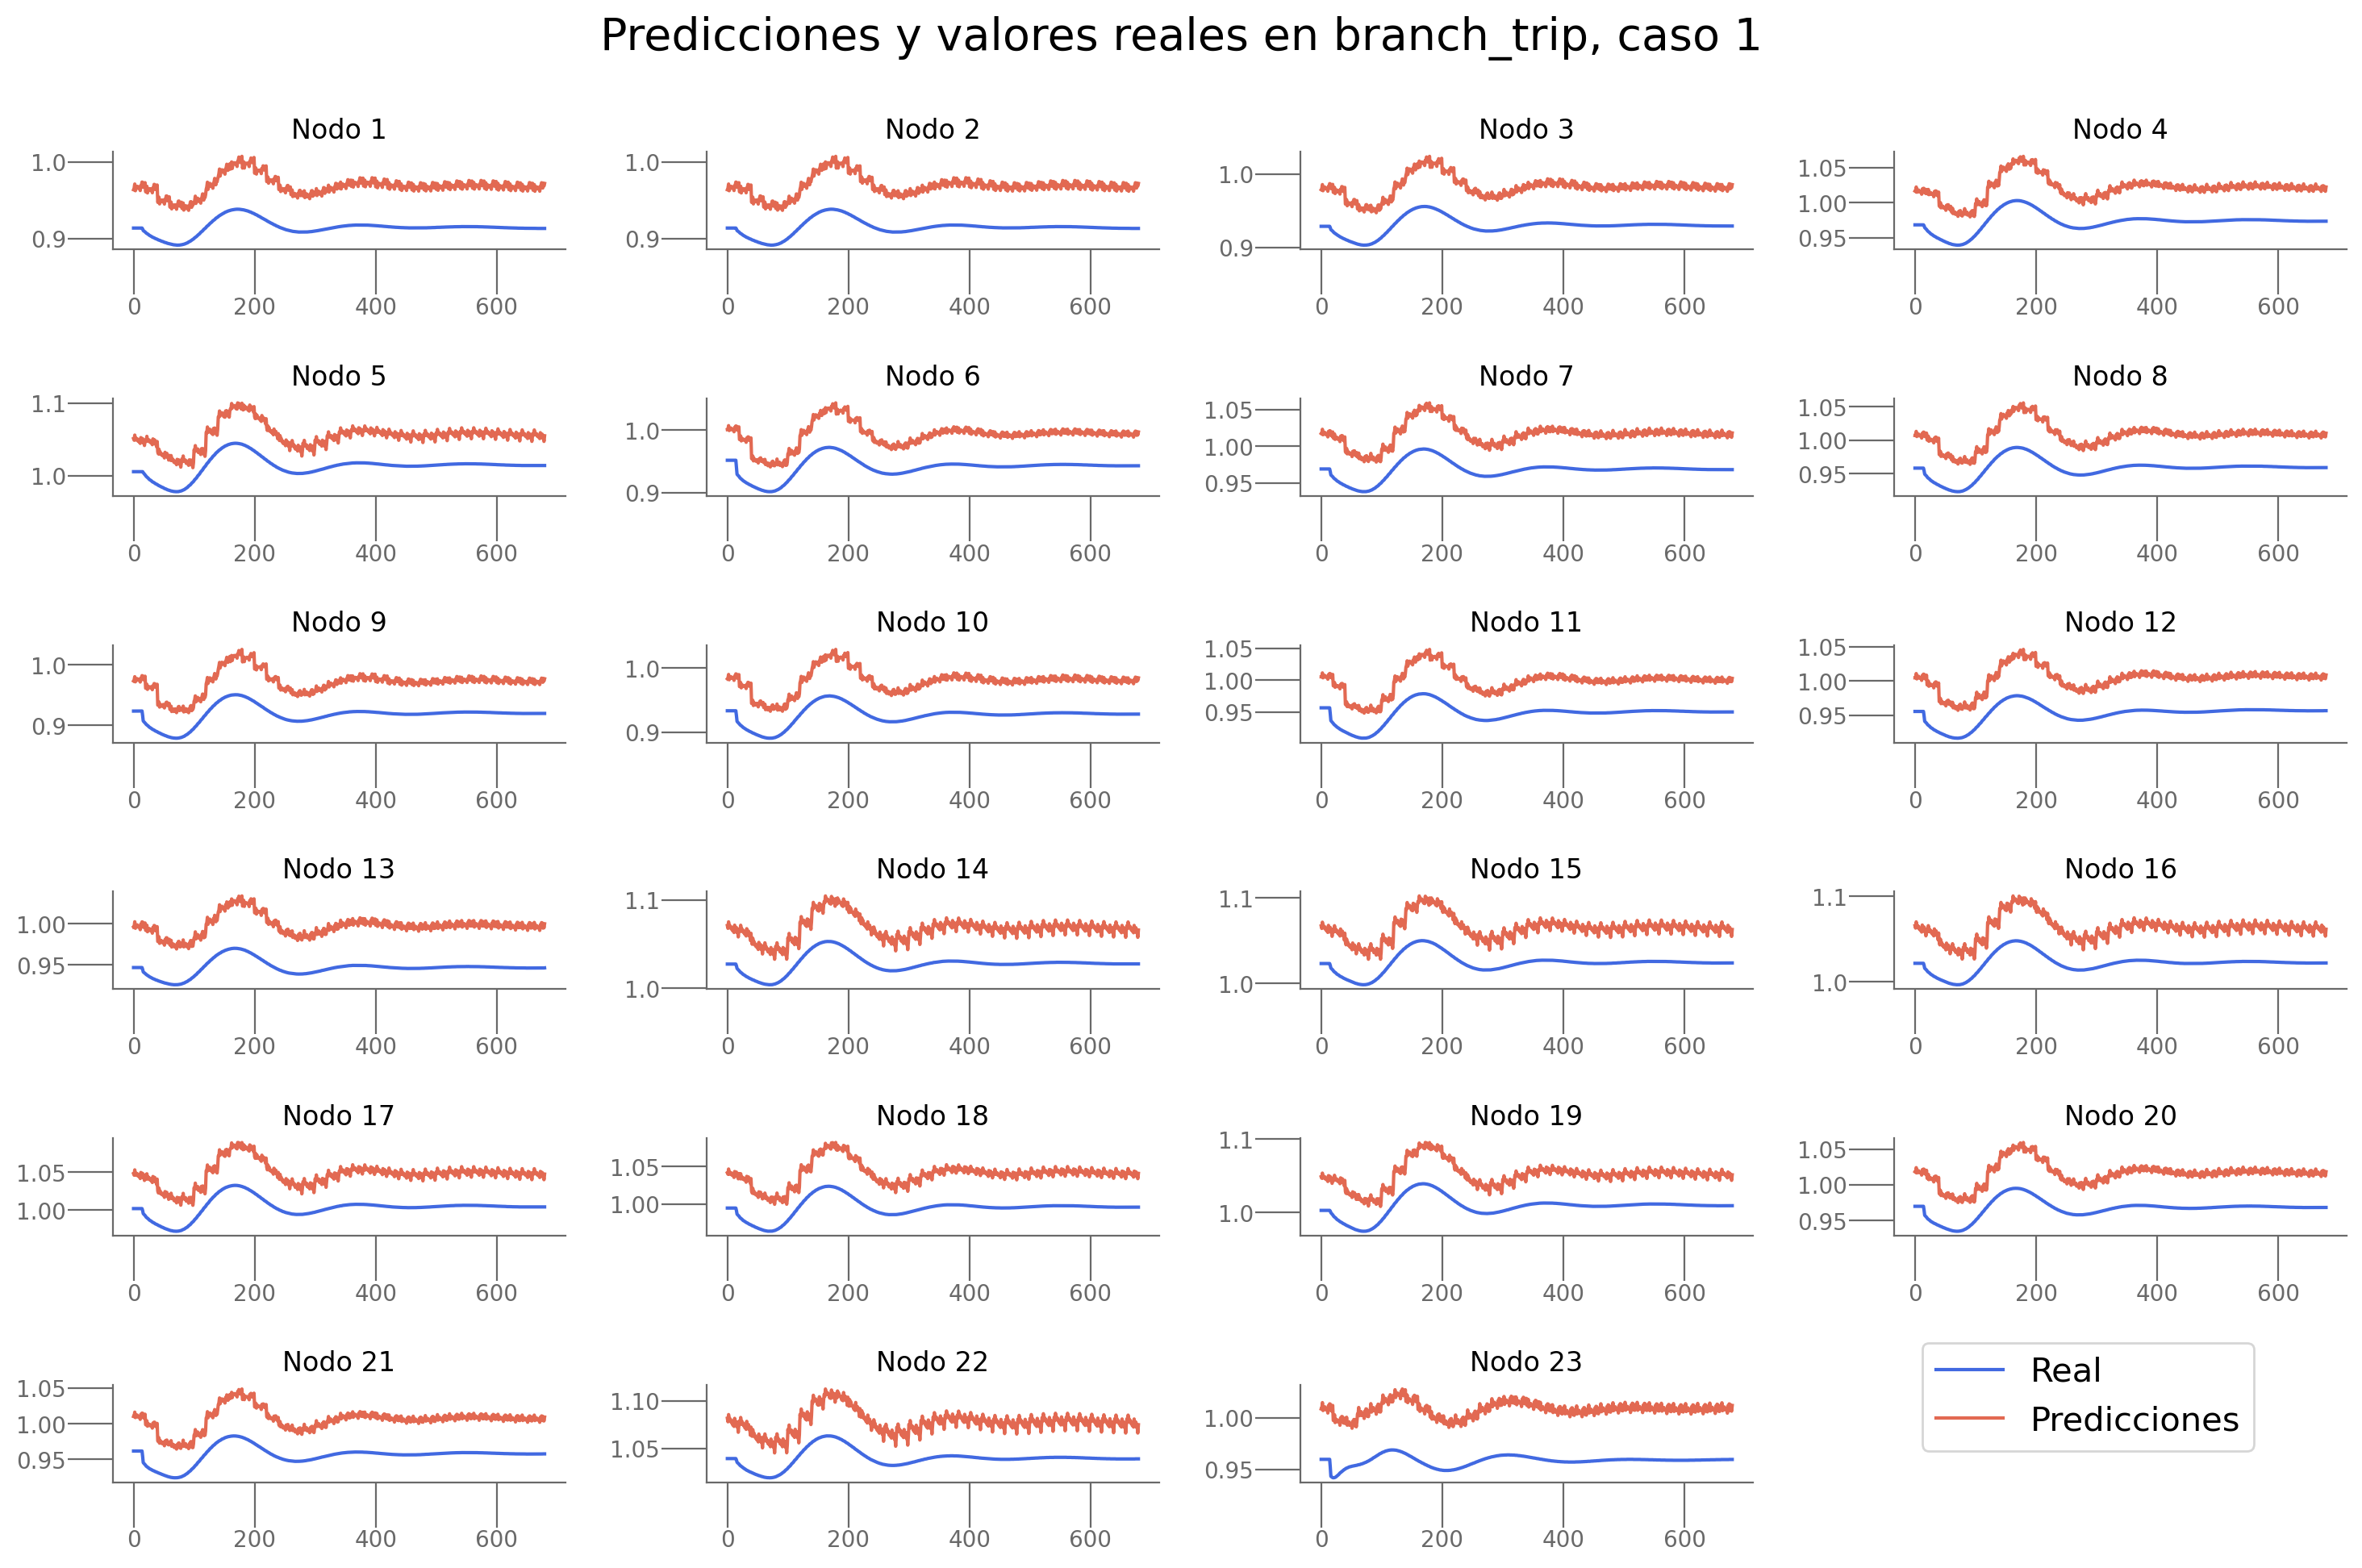

In [36]:
_,_,_, predictions_brt_ajuste,real_brt_ajuste = trainer_brt.test()
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [37]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params = params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
5     EvolveGCN                                                NaN   
6        ASTGCN                                                NaN   
7         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 2}   
8         DCRNN                                     {'hidden': 60}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.003700   0.398922   
1                                                NaN  0.004787  -1.839737   
2  .